### Importing images

In [1]:
import os, json
import subprocess, sys
import random
import math
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from tqdm import tqdm
import copy
import cv2
from PIL import Image, ImageDraw

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from transformers import MobileViTImageProcessor, MobileViTForSemanticSegmentation

2025-05-21 07:24:23.712029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747812263.943302      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747812264.010084      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
package_name = "evaluate"

try:
    __import__(package_name)
    print('already installed')
except ImportError:
    print(f"{package_name} is NOT installed! Installing now...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package_name]);

evaluate is NOT installed! Installing now...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.4.0.6 which is incompatible.
torch 2.6.0+cu124 requires nvidia-curand-cu12==10.3.5.147; platform_system == "Linux" and platform_ma

In [3]:
import wandb

WANDB_USER = "chri-project"  
WANDB_PROJECT = "ML4CV--assignment"
wandb.login(key='2b387b514b9fcec8902df2b863ae0646f56125d6')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: chridib (chri-project) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
!pip install segmentation-models-pytorch albumentations --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 2.5 MB/s eta 0:00:00:00:01


In [5]:
'''
wget -c http://images.cocodataset.org/zips/train2017.zip -q
unzip -q train2017.zip
rm train2017.zip
mv train2017 coco_images_train
'''

'\nwget -c http://images.cocodataset.org/zips/train2017.zip -q\nunzip -q train2017.zip\nrm train2017.zip\nmv train2017 coco_images_train\n'

In [6]:
'''

wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip -q
unzip -q annotations_trainval2017.zip
rm annotations_trainval2017.zip
mv annotations coco_annotations

wget -c http://images.cocodataset.org/zips/val2017.zip -q
unzip -q val2017.zip 
rm val2017.zip
mv val2017 coco_images_val'''

'\n\nwget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip -q\nunzip -q annotations_trainval2017.zip\nrm annotations_trainval2017.zip\nmv annotations coco_annotations\n\nwget -c http://images.cocodataset.org/zips/val2017.zip -q\nunzip -q val2017.zip \nrm val2017.zip\nmv val2017 coco_images_val'

In [7]:
def fix_random(seed: int) -> None:
    """
    Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=42)

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
import evaluate

"""
Source: https://github.com/hendrycks/anomaly-seg/issues/15#issuecomment-890300278
"""
COLORS = np.array([
    [  0,   0,   0],  # unlabeled    =   0,
    [ 70,  70,  70],  # building     =   1,
    [190, 153, 153],  # fence        =   2, 
    [250, 170, 160],  # other        =   3,
    [220,  20,  60],  # pedestrian   =   4, 
    [153, 153, 153],  # pole         =   5,
    [157, 234,  50],  # road line    =   6, 
    [128,  64, 128],  # road         =   7,
    [244,  35, 232],  # sidewalk     =   8,
    [107, 142,  35],  # vegetation   =   9, 
    [  0,   0, 142],  # car          =  10,
    [102, 102, 156],  # wall         =  11, 
    [220, 220,   0],  # traffic sign =  12,
    [ 60, 250, 240],  # anomaly      =  13,
]) 

## TODO: Show the imbalance of the classes, if any. In this way you can justify that there are errors
## TODO: create cocodataset in which you order each image with its own annotation, in this way you can remove the for loop inside random_anomaly_injection function

Distance maps are precomputed, as suggested by the paper Boundary loss for highly unbalanced segmentation, to avoid lengthen the training phase (requires 2 hours and 45 minutes). Computation is done one the resized image, to be an approximation as good as possible. 
They are stored in a compressed format and with float16 otherwise it would not be possible to store them in the memory of Kaggle (it would require about 400Gb at full size). 
I have saved them in the ML4CV-data to not have to compute them back every run (it cost about 2 hourse and 45 minutes)
Of course, precompute them is not ideal, since it does not take into account all the possible augmentations, cropping, etc. It's the only possibility to use them, otherwise is too expensive in terms of time.

In [10]:
class StreetHazardsDataset(Dataset):
    def __init__(self, odgt_file, coco_path_annotations = None, coco_path_images=None, image_resize=None, augment_both=None, augment_images=None, 
                 inject_anomalies = False, compute_dist_map = False):
        """
        Args:
            odgt_file (str): Path to the .odgt file (train, val, or test).
            transform (callable, optional): Transformations to apply to images and masks.
            compute_dist_map: is used to pre-compute the distance maps to use then in the Boundary loss.
        """

        self.augment_both = augment_both
        self.augment_images = augment_images
        self.image_resize = image_resize
        self.inject_anomalies = inject_anomalies
        self.coco_path_images = coco_path_images
        self.compute_dist_map = compute_dist_map
        self.path_to_distance_map = '/kaggle/input/distance_maps/distance_maps'
        
        if self.inject_anomalies:
            with open(coco_path_annotations, 'r') as file:
                    self.coco_data = json.load(file)

        # Load the .odgt file
        with open(odgt_file, "r") as f:
            odgt_data = json.load(f)
        

        self.paths = [
            {
                "image": os.path.join(Path(odgt_file).parent, data["fpath_img"]),
                "labels": os.path.join(Path(odgt_file).parent, data["fpath_segm"]),
                #"dist_map" : preprocess_distance_maps(os.path.join(Path(odgt_file).parent, data["fpath_segm"]), self.image_resize) if compute_dist_map else None
                "dist_map" : os.path.join(self.path_to_distance_map, f'{Path(data["fpath_segm"]).stem}.npz') if compute_dist_map else None
            }
            for data in odgt_data 
        ]
        
    def random_horizontal_flip(self, image, label, dist_map, p=0.5):
        if random.random() < p:
            image = torch.flip(image, dims=[-1])
            label = torch.flip(label, dims=[-1])
            dist_map = torch.flip(dist_map, dims=[-1])
        return image, label, dist_map
    
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):

        image = Image.open(self.paths[idx]["image"]).convert("RGB")
        labels = Image.open(self.paths[idx]["labels"])
        dist_map = np.load(self.paths[idx]["dist_map"])["dist"] if self.compute_dist_map else np.zeros(1)

        #to_tensor
        dist_map = torch.from_numpy(dist_map)
        image = transforms.ToTensor()(image)
        labels = torch.as_tensor(transforms.functional.pil_to_tensor(labels), dtype=torch.int64) - 1

        if self.image_resize:
            image = transforms.Resize(self.image_resize, transforms.InterpolationMode.BILINEAR)(image)
            labels = transforms.Resize(self.image_resize, transforms.InterpolationMode.NEAREST)(labels)
            
        if self.augment_both:
            image, labels, dist_map = self.random_horizontal_flip(image=image, label=labels, dist_map=dist_map, p=0.5)
            #image, labels, dist_map = self.augment_both(image, labels, dist_map)

        if self.inject_anomalies:
            
            image, labels = random_anomaly_injection(image, labels, self.coco_data, self.coco_path_images)
            

        #to_tensor
        '''image = transforms.ToTensor()(image)
        labels = torch.as_tensor(transforms.functional.pil_to_tensor(labels), dtype=torch.int64) - 1
        labels = labels.squeeze(0)'''
        
        labels = labels.squeeze(0)
        
        if self.augment_images:
            image = self.augment_images(image)

        return {'image' : image, 'labels' : labels, 'dist_map' : dist_map}

In [11]:
def visualize_annotation(annotation_img: np.ndarray|torch.Tensor, ax=None):
    """
    Adapted from https://github.com/CVLAB-Unibo/ml4cv-assignment/blob/master/utils/visualize.py
    """
    if ax is None: ax = plt.gca()
    annotation_img = np.asarray(annotation_img)
    img_new = np.zeros((*annotation_img.shape, 3))

    for index, color in enumerate(COLORS):
        img_new[annotation_img == index] = color

    ax.imshow(img_new / 255.0)
    ax.set_xticks([])
    ax.set_yticks([])
    #wandb.log({"examples": [wandb.Image(img_new / 255.0)]})
    
    

def visualize_scene(image: np.ndarray|torch.Tensor, ax=None):
    if ax is None: ax = plt.gca()
    image = np.asarray(image)
    ax.imshow(np.moveaxis(image, 0, -1))
    ax.set_xticks([])
    ax.set_yticks([])

In [12]:
class OutOfDistribution(Dataset):
    def __init__(self, split, directory):
        try:
            self.dataset = torchvision.datasets.VOCSegmentation(directory, image_set="train")
        except:
            self.dataset = torchvision.datasets.VOCSegmentation(directory, image_set="train", download=True)

    def __get_item__(self, idx):
        
        img, lbl = self.dataset[idx]
        return img, lbl

In [13]:
class MixDataset(Dataset):
    def __init__(self, inlier_dataset, outlier_dataset, anomaly_probability=1, max_anomalies = 4, anomaly_idx = 13):
        
        self.inlier_dataset = inlier_dataset
        self.outlier_dataset = outlier_dataset
        self.anomaly_idx = anomaly_idx
        self.anomaly_probability = anomaly_probability
        self.max_anomalies = max_anomalies

    def inject_anomalies(self, sh_img, sh_lbl):

        n_anomalies = random.randint(1, self.max_anomalies)
        for i in range(n_anomalies):

            rand_idx = random.randint(0, len(self.outlier_dataset)-1)

            anomaly_size = (np.random.randint(sh_img.shape[1]*0.1, sh_img.shape[1]*0.3), np.random.randint(sh_img.shape[2]*0.1, sh_img.shape[2]*0.3))
            i, j, h, w = transforms.RandomCrop.get_params(sh_img, output_size=anomaly_size)
            possible_classes = []
            while len(possible_classes) == 0: # In some cases there are no classes available
                anomaly_idx = np.random.randint(0, len(self.outlier_dataset))
                anomaly_image = transforms.ToTensor()(self.outlier_dataset[anomaly_idx][0])
                anomaly_annot = torch.from_numpy(np.array(self.outlier_dataset[anomaly_idx][1])).unsqueeze(0)
                possible_classes = np.unique(anomaly_annot)[1:-1]

            anomaly_class = np.random.choice(possible_classes)
            anomaly_image = F.interpolate(anomaly_image.unsqueeze(0), size=(h, w), mode="bilinear").squeeze(0)
            anomaly_annot = F.interpolate(anomaly_annot.unsqueeze(0), size=(h, w), mode="nearest").squeeze((0, 1))

            # Insert anomaly
            sh_img[:, i:i+h, j:j+w][:, anomaly_annot == anomaly_class] = anomaly_image[:, anomaly_annot == anomaly_class]
            sh_lbl[i:i+h, j:j+w][anomaly_annot == anomaly_class] = self.anomaly_idx
            anomaly_annot[anomaly_annot == anomaly_class] = self.anomaly_idx
            anomaly_annot[anomaly_annot != self.anomaly_idx] = 0

        return sh_img, sh_lbl, anomaly_image, anomaly_annot

    def __len__(self):
        return len(self.inlier_dataset)

    def __getitem__(self, idx):

        sh_img, sh_lbl, _ = self.inlier_dataset[idx].values()
        p = random.random()
        if p < self.anomaly_probability:
            sh_img, sh_lbl, ood_img, ood_lbl = self.inject_anomalies(sh_img, sh_lbl)
            w, h = sh_lbl.shape[0], sh_lbl.shape[1]
            ood_img = transforms.Resize((w, h), transforms.InterpolationMode.BILINEAR)(ood_img)
            ood_lbl = transforms.Resize((w, h), transforms.InterpolationMode.NEAREST)(ood_lbl.unsqueeze(0)).squeeze(0)

        return {"image" : sh_img,"labels": sh_lbl}
        #return sh_img, sh_lbl, ood_img, ood_lbl

In [14]:
'''
class CocoDataset(Dataset):
    def __init__(self, annotations_path, images_path):
        """
        Args:
            odgt_file (str): Path to the .odgt file (train, val, or test).
            transform (callable, optional): Transformations to apply to images and masks.
        """

        self.images_path = images_path
        
        with open(annotations_path, "r") as f:
            self.coco_data = json.load(f)
        
    def __len__(self):
        return len(os.listdir(self.images_path))

    def __getitem__(self, idx):

        annotations = self.coco_data['annotations'][idx]
        image_id = annotations['image_id']
        
        img_segmentation = annotations['segmentation'][0]
        bbox = list(map(int, annotations['bbox']))
        
        for img in self.coco_data['images']:
            if image_id == img['id']:
                name = img['file_name']
                im = cv2.imread(os.path.join(self.images_path, name))
                
                polygon = np.array([[int(img_segmentation[i]), int(img_segmentation[i + 1])] for i in                                        range(0, len(img_segmentation), 2)])
                mask = np.zeros((im.shape[0], im.shape[1]))
                cv2.fillConvexPoly(mask, polygon, 1)
        
                mask = mask > 0
                out = np.zeros_like(im)
                out[mask] = im[mask]
                x, y, w, h = bbox
                image_out = out[y:y+h, x:x+w]
                #plt.imshow(out)
        
                return image_out
'''

'\nclass CocoDataset(Dataset):\n    def __init__(self, annotations_path, images_path):\n        """\n        Args:\n            odgt_file (str): Path to the .odgt file (train, val, or test).\n            transform (callable, optional): Transformations to apply to images and masks.\n        """\n\n        self.images_path = images_path\n        \n        with open(annotations_path, "r") as f:\n            self.coco_data = json.load(f)\n        \n    def __len__(self):\n        return len(os.listdir(self.images_path))\n\n    def __getitem__(self, idx):\n\n        annotations = self.coco_data[\'annotations\'][idx]\n        image_id = annotations[\'image_id\']\n        \n        img_segmentation = annotations[\'segmentation\'][0]\n        bbox = list(map(int, annotations[\'bbox\']))\n        \n        for img in self.coco_data[\'images\']:\n            if image_id == img[\'id\']:\n                name = img[\'file_name\']\n                im = cv2.imread(os.path.join(self.images_path, name

In [15]:
def random_anomaly_injection(hazard_image, hazard_label, coco_data, coco_image_path, overlay_scale_range = (0.1, 0.4)):
    
    """
    randomly injects anomalies inside StreetHazards dataset
    to improve in terms of clarity
    """
    
    idx = np.random.randint(0, 36781)
    
    annotations = coco_data['annotations'][idx]
    
    image_id = annotations['image_id']
    
    while (type(annotations['segmentation']) != list):
        idx = np.random.randint(0, 36781)
        annotations = coco_data['annotations'][idx]
        image_id = annotations['image_id']
    
    img_segmentation = annotations['segmentation'][0]

    hazard_img = np.array(hazard_image.copy())
    hazard_lbl = np.array(hazard_label.copy())
    hazard_height, hazard_width, _ = hazard_img.shape

    #randomly compute the scale of the overlay
    overlay_scale  = random.uniform(*overlay_scale_range)
    overlay_size = (int(hazard_height*overlay_scale), int(hazard_width*overlay_scale))
    
    for img_info in coco_data['images']:
        if image_id == img_info['id']:
            name = img_info['file_name']
            coco_img = cv2.imread(f"{coco_image_path}/{name}")
            original_height, original_width = coco_img.shape[:2]
    
            # Create a binary mask from the segmentation polygon
            polygon = np.array(img_segmentation).reshape((-1, 2)).astype(np.int32)
            mask = np.zeros((original_height, original_width), dtype=np.uint8)
            cv2.fillPoly(mask, [polygon], 255)
    
            # Crop object and mask
            x, y, w, h = cv2.boundingRect(mask)
            segmented_object = coco_img[y:y + h, x:x + w]
            try:
                segmented_object = cv2.cvtColor(segmented_object, cv2.COLOR_BGR2RGB)
            except:
                break
            mask_cropped = mask[y:y + h, x:x + w]
        
            # Resize object and mask
            if segmented_object.size > 0:
                resized_object = cv2.resize(segmented_object, overlay_size, interpolation=cv2.INTER_LINEAR)
                resized_mask = cv2.resize(mask_cropped, overlay_size, interpolation=cv2.INTER_NEAREST)
                resized_mask_binary = resized_mask > 0
    
            # Random region in StreetHazards image to insert the anomaly
            roi_x = np.random.randint(0, hazard_width - overlay_size[0])
            roi_y = np.random.randint(0, hazard_height - overlay_size[1])
            roi = hazard_img[roi_y:roi_y + overlay_size[1], roi_x:roi_x + overlay_size[0]].copy()
    
            # Create a mask with the same number of channels as the ROI
            resized_mask_channels = np.expand_dims(resized_mask_binary, axis=-1).astype(float)
            if roi.ndim == 3:
                resized_mask_channels = np.repeat(resized_mask_channels, 3, axis=-1)
            elif roi.ndim == 2:
                resized_mask_channels = np.expand_dims(resized_mask_channels, axis=-1).astype(float) # For grayscale
    
            # Ensure resized_object has the same number of channels as roi
            if resized_object.ndim == 2 and roi.ndim == 3:
                resized_object_expanded = cv2.cvtColor(resized_object, cv2.COLOR_GRAY2BGR).astype(float) / 255.0
            elif resized_object.ndim == 3:
                resized_object = resized_object.astype(float) / 255.0
            else:
                print("Warning: Segmented object has incompatible dimensions for overlay.")
                continue
    
            roi = roi.astype(float) / 255.0
    
            # Blend the ROI with the resized segmented object using the mask
            masked_roi = (roi * (1 - resized_mask_channels))
            overlaid_part = (resized_object * resized_mask_channels)
            blended_roi = cv2.addWeighted(masked_roi, 1, overlaid_part, 1, 0)
            hazard_img[roi_y:roi_y + overlay_size[1], roi_x:roi_x + overlay_size[0]] = (blended_roi * 255).astype(np.uint8)

            # Apply the anomaly also in the label
            hazard_lbl[roi_y:roi_y + overlay_size[1], roi_x:roi_x + overlay_size[0]][resized_mask_binary] = 14

            hazard_img, hazard_lbl = Image.fromarray(hazard_img), Image.fromarray(hazard_lbl)
            return hazard_img, hazard_lbl

In [16]:
def compute_mean_std(loader):
    """
    compute mean and standard deviation to normalize the images; can be used in alternative of imagenet mean and std.
    (seems to worse results)
    """
    mean = 0.0
    std = 0.0
    nb_samples = 0

    for batch in tqdm(loader):
        images = batch["image"]
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1) 
    
        mean += images.mean(2).sum(0)  
        std += images.std(2).sum(0)
        nb_samples += batch_samples 
        del batch

    mean /= nb_samples
    std /= nb_samples
    return mean, std

In [17]:
import os
import numpy as np
import torch
from pathlib import Path
from typing import Tuple, Iterable, Set, cast
from scipy.ndimage import distance_transform_edt as eucl_distance
from torch import Tensor

def uniq(a: Tensor) -> Set:
    """
    taken from https://github.com/LIVIAETS/boundary-loss/blob/master/utils.py
    """
    return set(torch.unique(a.cpu()).numpy())
    
def sset(a: Tensor, sub: Iterable) -> bool:
    """
    taken from https://github.com/LIVIAETS/boundary-loss/blob/master/utils.py
    """
    return uniq(a).issubset(sub)

def simplex(t: Tensor, axis=1) -> bool:
    """
    taken from https://github.com/LIVIAETS/boundary-loss/blob/master/utils.py
    """
    _sum = cast(Tensor, t.sum(axis).type(torch.float32))
    _ones = torch.ones_like(_sum, dtype=torch.float32)
    return torch.allclose(_sum, _ones)

def one_hot(t: Tensor, axis=1) -> bool:
    """
    taken from https://github.com/LIVIAETS/boundary-loss/blob/master/utils.py
    """
    return simplex(t, axis) and sset(t, [0, 1])
    
def class2one_hot(seg: Tensor, K: int) -> Tensor:
    """
    taken from https://github.com/LIVIAETS/boundary-loss/blob/master/utils.py
    """
    # Breaking change but otherwise can't deal with both 2d and 3d
    # if len(seg.shape) == 3:  # Only w, h, d, used by the dataloader
    #     return class2one_hot(seg.unsqueeze(dim=0), K)[0]

    assert sset(seg, list(range(K))), (uniq(seg), K)

    b, *img_shape = seg.shape  # type: Tuple[int, ...]

    device = seg.device
    res = torch.zeros((b, K, *img_shape), dtype=torch.int32, device=device).scatter_(1, seg[:, None, ...], 1)

    assert res.shape == (b, K, *img_shape)
    assert one_hot(res)

    return res

def one_hot2dist(seg: np.ndarray, resolution: Tuple[float, float, float] = None,
                 dtype=None) -> np.ndarray:
    """
    taken from https://github.com/LIVIAETS/boundary-loss/blob/master/utils.py
    """
    assert one_hot(torch.tensor(seg), axis=0)
    K: int = len(seg)

    res = np.zeros_like(seg, dtype=dtype)
    for k in range(K):
        posmask = seg[k].astype(bool)

        if posmask.any():
            negmask = ~posmask
            res[k] = eucl_distance(negmask, sampling=resolution) * negmask \
                - (eucl_distance(posmask, sampling=resolution) - 1) * posmask
        # The idea is to leave blank the negative classes
        # since this is one-hot encoded, another class will supervise that pixel

    return res

def preprocess_distance_maps(
    label_path: str,
    image_resize,
    output_dir: str = "/kaggle/working/distance_maps",
    num_classes: int = 13,
    resolution: Tuple[float, float] = (1.0, 1.0)):
    
    """
    used to precompute the distance maps, used for the Boundary Loss. 
    Precomputation is necessary, it takes around 2 hours 45 minutes per each epoch -> too long
    """
    
    os.makedirs(output_dir, exist_ok=True)
    label = Image.open(label_path)
    
    #gt = np.array(label, dtype=np.int64) - 1
    #resized_gt = cv2.resize(gt, image_resize, interpolation=cv2.INTER_NEAREST)
    #gt_tensor = torch.tensor(label, dtype=torch.int64).unsqueeze(0) - 1# [1, H, W]
    gt_tensor = torch.as_tensor(transforms.functional.pil_to_tensor(label), dtype=torch.int64) - 1
    gt_tensor = transforms.Resize(image_resize, transforms.InterpolationMode.NEAREST)(gt_tensor)
    one_hot = class2one_hot(gt_tensor, K=num_classes).squeeze(0)  # [C, H, W]
    dist_map = one_hot2dist(one_hot.numpy(), resolution=resolution)  # [C, H, W]
    output_path = Path(output_dir) / Path(label_path).stem
    np.savez_compressed(output_path, dist=dist_map.astype(np.float16))
    
    #np.save(output_path, dist_map.astype(np.float16))
    #print(f"Saved distance map to {output_path}")
    
    return output_path


In [18]:
image_resize = (512, 896)

train_dataset = StreetHazardsDataset(
    odgt_file= "/kaggle/input/streethazards_train/train/train.odgt",
    image_resize = image_resize,
    augment_both=None,
    augment_images=None,
    inject_anomalies=False,
    compute_dist_map=True
)

In [19]:
def compute_class_frequency(dataset, num_classes=13, normalize = True):
    """
    used to count the number of pixels per class, to understand how much a pixel is common to be a class or another one
    return: the computed weights
    """
    data_loader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)
    pixels_per_class = torch.zeros(num_classes, dtype=torch.long)

    for batch in tqdm(data_loader):
        labels = batch['labels']  # Assumes shape: (B, H, W)
        labels = labels.view(-1)  # Flatten all pixels
        counts = torch.bincount(labels, minlength=num_classes)
        pixels_per_class += counts

    total_pixels = pixels_per_class.sum()
    frequencies = pixels_per_class.float() / total_pixels
    weights = 1.0 / frequencies
    if normalize:
        weights = weights / weights.sum() * len(weights)

    return weights

#weight_ce = compute_class_frequency(dataset= train_dataset, num_classes=13, normalize = True)
#print(weight_ce)

In [20]:
#!zip -r distance_maps.zip distance_maps

In [ ]:
idx = 2
img, lbl, _ = train_dataset[idx].values()
print(img.shape, lbl.shape)
visualize_scene(img)

torch.Size([3, 512, 896]) torch.Size([512, 896])


In [ ]:
#compute mean and std on resized images should give better results, if the resize is the same used in the training
train_dl = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
#mean_streethazards, std_streethazards = compute_mean_std(train_dl)
#print(mean_streethazards, std_streethazards)

In [ ]:
mean_imagenet, std_imagenet = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [24]:
image_resize = (512, 896)

augment_both = transforms.v2.Compose([
    #transforms.v2.RandomCrop(image_resize_scale),
    #transforms.v2.RandomResizedCrop(image_resize, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.v2.RandomHorizontalFlip(),
])

augment_images = transforms.Compose([
    transforms.Normalize(mean = mean_imagenet, std = std_imagenet),
    #transforms.Normalize(mean = mean_streethazards, std = std_streethazards),
    #transforms.RandomErasing(scale=(0.02, 0.15))
])

#only apply resize, to_tensor and normalization (computed on train)
augment_val_test = transforms.Normalize(
    #mean = mean_streethazards, std = std_streethazards
    mean = mean_imagenet, std = std_imagenet
)

#Create dataset
train_dataset = StreetHazardsDataset(
    odgt_file="/kaggle/input/streethazards_train/train/train.odgt",
    image_resize = image_resize,
    #augment_both=None,
    augment_both=augment_both,
    augment_images=augment_images,
    inject_anomalies = False,
    coco_path_annotations = "/kaggle/working/coco_annotations/instances_val2017.json",
    coco_path_images = "/kaggle/working/coco_images_val",
    compute_dist_map=True
)

val_dataset = StreetHazardsDataset(
    odgt_file="/kaggle/input/streethazards_train/train/validation.odgt",
    image_resize = image_resize,
    augment_both=None,
    augment_images=augment_val_test,
    inject_anomalies = False,
    coco_path_annotations = "/kaggle/working/coco_annotations/instances_val2017.json",
    coco_path_images = "/kaggle/working/coco_images_val",
)

test_dataset = StreetHazardsDataset(
    odgt_file="/kaggle/input/streethazards_test/test/test.odgt",
    image_resize = image_resize,
    augment_both=None,
    augment_images=augment_val_test,
    inject_anomalies = False,
)

tensor([-0.2513,  0.0476,  0.5834])
tensor([-156.,  157.,    0.,  636.,    0.,  171.,  298.,  275.,  266.,    0.,
         263.,  206.,  643.], dtype=torch.float16)


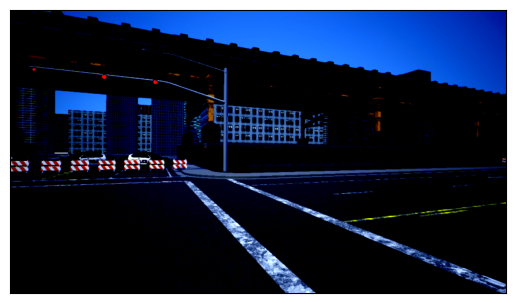

In [25]:
idx = 2
img, lbl, dist_map = train_dataset[idx].values()
visualize_scene(img)
print(img[:, 0, -1])
print(dist_map[:, 0, -1])

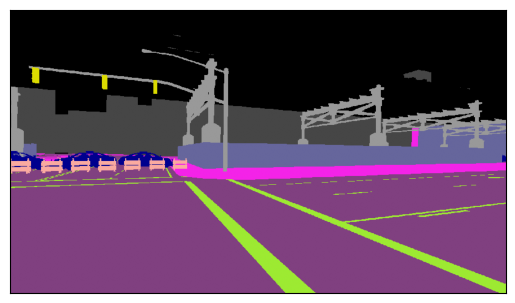

In [26]:
visualize_annotation(lbl)

### data loader creations

In [27]:
#used to create a dataset with random samples and 1/4 of the elements of the biggest one, to make some trial
reduction_idx = 8
l_shift = (len(train_dataset)//reduction_idx)%8
indices = np.random.choice(len(train_dataset), size=len(train_dataset)//reduction_idx-l_shift, replace=False)
sampler = SubsetRandomSampler(indices)

#train_dl = DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=2, sampler=sampler)
train_dl = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_dl = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_dl = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

In [28]:
def as_numpy(obj):
    if torch.is_tensor(obj):
        return obj.cpu().numpy()
    else:
        return np.array(obj)

In [29]:
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

def get_model(model_name, num_classes, weights_path = None):

    if "segformer" in model_name:
        processor = AutoImageProcessor.from_pretrained(model_name)
        model = SegformerForSemanticSegmentation.from_pretrained(model_name, num_labels=num_classes, ignore_mismatched_sizes=True, semantic_loss_ignore_index = 13)
    elif "deeplabv3":
        processor = MobileViTImageProcessor.from_pretrained(model_name)
        model = MobileViTForSemanticSegmentation.from_pretrained(model_name, num_labels=num_classes, ignore_mismatched_sizes=True, semantic_loss_ignore_index = 13)
    
    if weights_path:
        model.load_state_dict(torch.load(weights_path))
        
    model.to(DEVICE);
    
    return processor, model

In [30]:
class MeanIoU:
    """
    taken from https://github.com/Jun-CEN/Open-World-Semantic-Segmentation/blob/main/DeepLabV3Plus-Pytorch/metrics/stream_metrics.py
    """
    def __init__(self, n_classes= 13):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))
        
    def update(self, label_trues, logits):
        label_preds = torch.argmax(logits, dim=1)
        label_preds, label_trues = label_preds.cpu().numpy(), label_trues.cpu().numpy()
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist( lt.flatten(), lp.flatten())

    def _fast_hist(self, label_true, label_pred):
        mask = (label_true >= 0) & (label_true < self.n_classes)
        hist = np.bincount(
            self.n_classes * label_true[mask].astype(int) + label_pred[mask],
            minlength=self.n_classes ** 2,
        ).reshape(self.n_classes, self.n_classes)
        return hist

    def get_results(self):
        """Returns accuracy score evaluation result.
            - overall accuracy
            - mean accuracy
            - mean IU
            - fwavacc
        """
        hist = self.confusion_matrix
        acc = np.diag(hist).sum() / hist.sum()
        acc_cls = np.diag(hist) / hist.sum(axis=1)
        acc_cls = np.nanmean(acc_cls)
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu, axis= 0)
        freq = hist.sum(axis=1) / hist.sum()
        fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
        cls_iu = dict(zip(range(self.n_classes), iu))

        return {
                "Overall Acc": acc,
                "Mean Acc": acc_cls,
                "FreqW Acc": fwavacc,
                "Mean IoU": mean_iu,
                "Class IoU": cls_iu,
            }


In [31]:
from sklearn import metrics

def get_measures(_pos, _neg):
    pos = np.array(_pos[:]).reshape((-1, 1))
    neg = np.array(_neg[:]).reshape((-1, 1))
    examples = np.squeeze(np.vstack((pos, neg)))
    labels = np.zeros(len(examples), dtype=np.int32)
    labels[:len(pos)] += 1

    auroc = metrics.roc_auc_score(labels, examples)
    aupr = metrics.average_precision_score(labels, examples)

    return auroc, aupr


def get_aupr(confs, seg_labels, out_label=13):
    
    in_scores = confs[seg_labels != out_label]
    out_scores = confs[seg_labels == out_label]
    
    if (len(out_scores) != 0) and (len(in_scores) != 0):
        
        auprs = []
        measures = get_measures(in_scores, out_scores)
        auprs.append(measures[1])
        aupr = np.mean(auprs)

    return aupr

In [32]:
from kornia.morphology import dilation, erosion
from scipy import ndimage as ndi

d_k1 = torch.zeros((1, 1, 2 * 1 + 1, 2 * 1 + 1)).cuda()
d_k2 = torch.zeros((1, 1, 2 * 2 + 1, 2 * 2 + 1)).cuda()
d_k3 = torch.zeros((1, 1, 2 * 3 + 1, 2 * 3 + 1)).cuda()
d_k4 = torch.zeros((1, 1, 2 * 4 + 1, 2 * 4 + 1)).cuda()
d_k5 = torch.zeros((1, 1, 2 * 5 + 1, 2 * 5 + 1)).cuda()
d_k6 = torch.zeros((1, 1, 2 * 6 + 1, 2 * 6 + 1)).cuda()
d_k7 = torch.zeros((1, 1, 2 * 7 + 1, 2 * 7 + 1)).cuda()
d_k8 = torch.zeros((1, 1, 2 * 8 + 1, 2 * 8 + 1)).cuda()
d_k9 = torch.zeros((1, 1, 2 * 9 + 1, 2 * 9 + 1)).cuda()

d_ks = {1: d_k1, 2: d_k2, 3: d_k3, 4: d_k4, 5: d_k5, 6: d_k6, 7: d_k7, 8: d_k8, 9: d_k9}


selem = torch.ones((3, 3)).cuda()
selem_dilation = torch.FloatTensor(ndi.generate_binary_structure(2, 1)).cuda()

for k, v in d_ks.items():
    v[:,:,k,k] = 1
    for i in range(k):
        v = dilation(v, selem_dilation)
    d_ks[k] = v.squeeze(0).squeeze(0)

def find_boundaries(labels):
    """
    Calculate boundary mask by getting diff of dilated and eroded prediction maps
    """
    assert len(labels.shape) == 4
    boundaries = (dilation(labels.float(), selem_dilation) != erosion(labels.float(), selem)).float()
    ### save_image(boundaries, f'boundaries_{boundaries.float().mean():.2f}.png', normalize=True)

    return boundaries

def expand_boundaries(boundaries, r=0):
    """
    Expand boundary maps with the rate of r
    """
    if r == 0:
        return boundaries
    expanded_boundaries = dilation(boundaries, d_ks[r])
    ### save_image(expanded_boundaries, f'expanded_boundaries_{r}_{boundaries.float().mean():.2f}.png', normalize=True)
    return expanded_boundaries

In [33]:
class BoundarySuppressionWithSmoothing(nn.Module):
    """
    Apply boundary suppression and dilated smoothing
    """
    def __init__(self, boundary_suppression=True, boundary_width=4, boundary_iteration=4,
                 dilated_smoothing=True, kernel_size=7, dilation=6):
        super(BoundarySuppressionWithSmoothing, self).__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.boundary_suppression = boundary_suppression
        self.boundary_width = boundary_width
        self.boundary_iteration = boundary_iteration

        sigma = 1.0
        size = 7
        gaussian_kernel = np.fromfunction(lambda x, y: (1/(2*math.pi*sigma**2)) * math.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
        gaussian_kernel /= np.sum(gaussian_kernel)
        gaussian_kernel = torch.Tensor(gaussian_kernel).unsqueeze(0).unsqueeze(0)
        self.dilated_smoothing = dilated_smoothing

        self.first_conv = nn.Conv2d(1, 1, kernel_size=3, stride=1, bias=False)
        self.first_conv.weight = torch.nn.Parameter(torch.ones_like((self.first_conv.weight)))

        self.second_conv = nn.Conv2d(1, 1, kernel_size=self.kernel_size, stride=1, dilation=self.dilation, bias=False)
        self.second_conv.weight = torch.nn.Parameter(gaussian_kernel)


    def forward(self, x, prediction=None):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        x_size = x.size()
        # B x 1 x H x W
        assert len(x.shape) == 4
        out = x
        if self.boundary_suppression:
            # obtain the boundary map of width 2 by default
            # this can be calculated by the difference of dilation and erosion
            boundaries = find_boundaries(prediction.unsqueeze(1))
            expanded_boundaries = None
            if self.boundary_iteration != 0:
                assert self.boundary_width % self.boundary_iteration == 0
                diff = self.boundary_width // self.boundary_iteration
            for iteration in range(self.boundary_iteration):
                if len(out.shape) != 4:
                    out = out.unsqueeze(1)
                prev_out = out
                # if it is the last iteration or boundary width is zero
                if self.boundary_width == 0 or iteration == self.boundary_iteration - 1:
                    expansion_width = 0
                # reduce the expansion width for each iteration
                else:
                    expansion_width = self.boundary_width - diff * iteration - 1
                # expand the boundary obtained from the prediction (width of 2) by expansion rate
                expanded_boundaries = expand_boundaries(boundaries, r=expansion_width)
                # invert it so that we can obtain non-boundary mask
                non_boundary_mask = 1. * (expanded_boundaries == 0)

                f_size = 1
                num_pad = f_size

                # making boundary regions to 0
                x_masked = out * non_boundary_mask
                x_padded = nn.ReplicationPad2d(num_pad)(x_masked)

                non_boundary_mask_padded = nn.ReplicationPad2d(num_pad)(non_boundary_mask)

                # sum up the values in the receptive field
                y = self.first_conv(x_padded)
                # count non-boundary elements in the receptive field
                num_calced_elements = self.first_conv(non_boundary_mask_padded)
                num_calced_elements = num_calced_elements.long()

                # take an average by dividing y by count
                # if there is no non-boundary element in the receptive field,
                # keep the original value
                avg_y = torch.where((num_calced_elements == 0), prev_out, y / num_calced_elements)
                out = avg_y

                # update boundaries only
                out = torch.where((non_boundary_mask == 0), out, prev_out)
                del expanded_boundaries, non_boundary_mask

            # second stage; apply dilated smoothing
            if self.dilated_smoothing == True:
                out = nn.ReplicationPad2d(self.dilation * 3)(out)
                out = self.second_conv(out)

            return out.squeeze(1)
        else:
            if self.dilated_smoothing == True:
                out = nn.ReplicationPad2d(self.dilation * 3)(out)
                out = self.second_conv(out)
            else:
                out = x

        return out.squeeze(1)


In [34]:
def compute_anomaly_score(score, mode='energy'):
    """
    anomaly score computation used by the RPL paper, taken by them
    """
    #score = score.squeeze()[:13]

    if mode == 'energy':
        anomaly_score = -(1. * torch.logsumexp(score, dim=0))
    elif mode == 'entropy':
        prob = torch.softmax(score, dim=0)
        anomaly_score = -torch.sum(prob * torch.log(prob), dim=0) / torch.log(torch.tensor(13.))
    else:
        raise NotImplementedError

    # regular gaussian smoothing
    '''anomaly_score = anomaly_score.unsqueeze(0)
    anomaly_score = transforms.GaussianBlur(7, sigma=1)(anomaly_score)
    anomaly_score = anomaly_score.squeeze(0)'''
    return anomaly_score

In [71]:
def energy_entropy_anomaly_score(score, alpha = 1):
    """
    function that compute the anomaly score, based on the new paper Open-set Anomaly Segmentation in Complex Scenarios
    the code was not provided so i written it by my self.
    this function compute both the energy and entropy score and combine them to have the best anomaly detection
    alpha = 1 is taken by the paper
    """
    
    #score = score.squeeze(0)[:13]

    energy_score = 1. * torch.logsumexp(score, dim=0)
    prob = torch.softmax(score, dim=0)
    entropy_score = torch.sum(-prob * torch.log(prob), dim=0)# / torch.log(torch.tensor(13.))
    
    anomaly_score = alpha*entropy_score - energy_score
    
    #check whether the gaussian blur from the RPL paper is useful here
    anomaly_score = anomaly_score.unsqueeze(0)
    anomaly_score = transforms.GaussianBlur(7, sigma=1)(anomaly_score)
    anomaly_score = anomaly_score.squeeze(0)
    
    return anomaly_score

In [36]:
def disimilarity_entropy(logits, vanilla_logits, t=1.):
    """
    loss from RPL anomaly detection
    taken from https://github.com/yyliu01/RPL/blob/main/rpl_corocl.code/loss/PositiveEnergy.py
    """
    n_prob = torch.clamp(torch.softmax(vanilla_logits, dim=1), min=1e-7)
    a_prob = torch.clamp(torch.softmax(logits, dim=1), min=1e-7)

    n_entropy = -torch.sum(n_prob * torch.log(n_prob), dim=1) / t
    a_entropy = -torch.sum(a_prob * torch.log(a_prob), dim=1) / t

    entropy_disimilarity = F.mse_loss(input=a_entropy, target=n_entropy, reduction="none")
    assert ~torch.isnan(entropy_disimilarity).any(), print(torch.min(n_entropy), torch.max(a_entropy))

    return entropy_disimilarity


def energy_loss(logits, targets, vanilla_logits, out_idx=13, t=1.):
    """
    loss from RPL anomaly detection
    taken from https://github.com/yyliu01/RPL/blob/main/rpl_corocl.code/loss/PositiveEnergy.py
    """
    out_msk = (targets == out_idx)
    void_msk = (targets == 255)

    pseudo_targets = torch.argmax(vanilla_logits, dim=1)
    outlier_msk = (out_msk | void_msk)
    entropy_part = F.cross_entropy(input=logits, target=pseudo_targets, reduction='none')[~outlier_msk]
    reg = disimilarity_entropy(logits=logits, vanilla_logits=vanilla_logits)[~outlier_msk]
    if torch.sum(out_msk) > 0:
        logits = logits.flatten(start_dim=2).permute(0, 2, 1)
        #used relu since is equal to max()
        energy_part = F.relu(torch.log(torch.sum(torch.exp(logits),dim=2))[out_msk.flatten(start_dim=1)]).mean()
    else:
        energy_part = torch.tensor([.0], device=targets.device)
    return {"entropy_part": entropy_part.mean(), "reg": reg.mean(), "energy_part": energy_part}


def energy_entropy_loss(logits, targets, vanilla_logits, out_idx=13, t=1., alpha = 1):
    """
    TODO: finish to implement it following the formula on the paper
    loss from Open-set Anomaly Segmentation in Complex Scenarios (code not published yet)
    """
    out_msk = (targets == out_idx)
    void_msk = (targets == 255)

    pseudo_targets = torch.argmax(vanilla_logits, dim=1)
    outlier_msk = (out_msk | void_msk)
    entropy_part = F.cross_entropy(input=logits, target=pseudo_targets, reduction='none')[~outlier_msk]
    reg = disimilarity_entropy(logits=logits, vanilla_logits=vanilla_logits)[~outlier_msk]
    
    if torch.sum(out_msk) > 0:
        
        prob = torch.softmax(logits, dim=1).flatten(start_dim=2).permute(0, 2, 1)
        logits = logits.flatten(start_dim=2).permute(0, 2, 1)
        
        energy = torch.log(torch.sum(torch.exp(logits),dim=2))
        entropy = torch.sum(-prob * torch.log(prob), dim=2) / torch.log(torch.tensor(13.))
        outlier_part = -torch.log(torch.sigmoid(-energy[out_msk.flatten(start_dim=1)])) - alpha*(entropy[out_msk.flatten(start_dim=1)])
        inlier_part = torch.log(1 - torch.sigmoid(-energy[~out_msk.flatten(start_dim=1)])) + alpha*(entropy[~out_msk.flatten(start_dim=1)])
        energy_entropy = outlier_part.mean() - inlier_part.mean()
        
    else:
        energy_entropy = torch.tensor([.0], device=targets.device).mean()

    return entropy_part.mean() + reg.mean() + 0.05*energy_entropy
    #return {"entropy_part": entropy_part.mean(), "reg": reg.mean(), "energy_part": energy_entropy}


In [37]:
#The followings are scheduler used to balance the weights of the Region Loss and the Boundary loss during the loss computation, as written in the paper Boundary loss for highly unbalanced segmentation

class Dummy_scheduler():
    "inspired by Boundary loss for highly unbalanced segmentation"
    def __init__(self, alpha = 1, beta = 1):
        """
        alpha equals to beta is the configuration leading to the best result in the paper, when alpha is constant
        """
        self.alpha = alpha
        self.beta = beta
    def __call__(self, region_loss, boundary_loss):
        loss_res = self.beta*region_loss + self.alpha*boundary_loss
        return loss_res

class Increamental_scheduler():
    "inspired by Boundary loss for highly unbalanced segmentation"
    def __init__(self, alpha = 0.01, beta = 1, n_epochs = 100):
        self.alpha = alpha
        self.beta = beta
        # i would like to have the same weight in the last 1/10 epochs
        self.increment = abs(self.alpha - self.beta)/(n_epochs-(n_epochs/10))
    def __call__(self, region_loss, boundary_loss):
        loss_res = self.beta*region_loss + self.alpha*boundary_loss
        if self.alpha < self.beta:
            self.alpha = self.alpha + self.increment
        return loss_res

class Rebalance_scheduler():
    "inspired by Boundary loss for highly unbalanced segmentation"
    def __init__(self, alpha_start = 0.01, n_epochs = 100, alpha_end=0.99):
        """
        this scheduler is the one that leads to best results in the paper
        """
        self.alpha_end = alpha_end
        self.alpha_start = alpha_start
        self.alpha = alpha_start #start with 0.01
        self.beta = 1-self.alpha
        self.increment = abs(self.alpha - self.beta)/n_epochs
        self.e = 0

    def update_weights(self, epoch):
        self.alpha = min(self.alpha_start + epoch * self.increment, self.alpha_end)
        self.beta = 1-self.alpha

    def __call__(self, region_loss, boundary_loss, epoch):
        loss_res = self.beta*region_loss + self.alpha*boundary_loss
        if self.e != epoch:
            print(f"before update alpha: {self.alpha}, beta: {self.beta}")
            self.update_weights(epoch)
            print(f"after update alpha: {self.alpha}, beta: {self.beta}")
            self.e +=1
        return loss_res

In [38]:
from torch.optim.lr_scheduler import _LRScheduler

class WarmUpPolyLRScheduler(_LRScheduler):
    def __init__(self, optimizer, start_lr, total_iters, warmup_steps=0, lr_power=0.9, end_lr=1e-8, last_epoch=-1):
        self.start_lr = start_lr
        self.total_iters = total_iters
        self.warmup_steps = warmup_steps
        self.lr_power = lr_power
        self.end_lr = end_lr
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        cur_iter = self.last_epoch
        if cur_iter < self.warmup_steps:
            lr = self.start_lr * (cur_iter / self.warmup_steps)
        else:
            lr = self.start_lr * ((1 - float(cur_iter) / self.total_iters) ** self.lr_power)
            lr = np.clip(lr, a_min=self.end_lr, a_max=self.start_lr)

        return [lr for _ in self.optimizer.param_groups]

In [39]:
class Trainer:
    def __init__(self,
                 #processor,
                 model: nn.Module,
                 train_loader: DataLoader,
                 val_loader: DataLoader,
                 device: torch.device,
                 num_classes: int,
                 cfg: dict,
                 model_name: str,
                 loss = None,
                 contrastive_loss = None,
                 region_loss = None,
                 boundary_loss= None,
                 loss_scheduler= None,
                 resume_ckpt: dict = None,
                 
        ) -> None:

        self.loss_scheduler = loss_scheduler
        self.model_name = model_name
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_classes = num_classes
        self.patience = cfg["patience"]
        self.multi_scale = BoundarySuppressionWithSmoothing()
        self.multi_scale.to(DEVICE)
        self.loss = loss
        self.contrastive_loss = contrastive_loss
        self.boundary_loss = boundary_loss
        self.region_loss = region_loss
        #self.processor = processor
        
        if resume_ckpt:

            self.model = model.to(device)
            self.model.load_state_dict(resume_ckpt['model_state_dict'])
            
            self.num_epochs = cfg["num_epochs"] - resume_ckpt['epoch']
            num_steps = self.num_epochs * len(train_loader)
            
            self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
            self.optimizer.load_state_dict(resume_ckpt['optimizer_state_dict'])
            
            self.scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, cfg["lr"], total_steps=num_steps)
            self.scheduler.load_state_dict(resume_ckpt['scheduler_state_dict'])
            
        else:
            self.model = model.to(device)
            self.num_epochs = cfg["num_epochs"]
            num_steps = self.num_epochs * len(train_loader)
            self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
            #self.scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, cfg["lr"], total_steps=num_steps)
            self.scheduler = WarmUpPolyLRScheduler(self.optimizer, start_lr= cfg["lr"], total_iters= num_steps)

        self.mean_iou = 0.0
        self.step = 0
        self.best_acc = 0.0

        self.ckpt_path = Path("ckpts")
        self.ckpt_path.mkdir(exist_ok=True)

        wandb.init(name=cfg["run_name"], entity=WANDB_USER, project=WANDB_PROJECT, config=cfg)


    def train(self, verbose= False) -> None:
        
        for epoch in tqdm(range(self.num_epochs), desc="Epoch"):
            
            self.model.train()

            losses = []
            region_losses = []
            boundary_losses = []

            for batch in self.train_loader:

                #to remove the contrastive_loss just delete this if
                if self.contrastive_loss:

                    city_mix_imgs, city_mix_targets, ood_imgs, ood_targets = batch
                    city_mix_imgs, city_mix_targets = city_mix_imgs.to(self.device), city_mix_targets.to(self.device)
                    ood_imgs, ood_targets = ood_imgs.to(self.device), ood_targets.to(self.device)
                    ood_indices = [13 in i for i in city_mix_targets]
                    
                    input_data = torch.cat([city_mix_imgs, ood_imgs], dim=0)
                    half_batch_size = int(input_data.shape[0] / 2)
                    non_residual_logits, residual_logits, projects = self.model(input_data)
    
                    city_vanilla_logits, city_mix_logits, city_proj = \
                        non_residual_logits[:half_batch_size], residual_logits[:half_batch_size], projects[:half_batch_size]
    
                    ood_logits, ood_proj = residual_logits[half_batch_size:], projects[half_batch_size:]
                    contras_loss = self.contrastive_loss(city_proj=city_proj[ood_indices],
                                                     city_gt=city_mix_targets[ood_indices],
                                                     city_pred=city_mix_logits[ood_indices],
                                                     ood_pred=ood_logits[ood_indices],
                                                     ood_proj=ood_proj[ood_indices], ood_gt=ood_targets[ood_indices]) 

                    loss_dict = self.loss(logits=city_mix_logits, targets=city_mix_targets.clone(),
                                         vanilla_logits=city_vanilla_logits)
                    
                    inlier_loss = loss_dict["entropy_part"] + loss_dict["reg"]
                    outlier_loss = loss_dict["energy_part"] * 0.05 # 0.05 = energy_weight (taken from paper)
                    loss_res = inlier_loss + outlier_loss + contras_loss

                    del city_mix_imgs, city_mix_targets
                    del ood_imgs, ood_targets
                    
                else:    
                    
                    imgs = batch['image'].to(self.device)
                    labels = batch['labels'].to(self.device)
                    if self.loss == energy_loss:
    
                        vanilla_logits, mix_logits = self.model(imgs)
                        loss_dict = self.loss(logits=mix_logits, targets=labels.clone(),
                                             vanilla_logits=vanilla_logits)
                        inlier_loss = loss_dict["entropy_part"] + loss_dict["reg"]
                        outlier_loss = loss_dict["energy_part"] * 0.05 # 0.05 = energy_weight (taken from paper)
                        loss_res = inlier_loss + outlier_loss

                    elif self.loss == energy_entropy_loss:

                        vanilla_logits, mix_logits = self.model(imgs)
                        loss_res = self.loss(logits=mix_logits, targets=labels.clone(),
                                             vanilla_logits=vanilla_logits)
    
                        
                    else:
                        #dist_map are precomputed to avoid time losing
                        dist_map = batch['dist_map'].to(self.device)
                        
                        logits = self.model(imgs)
                        
                        if not self.boundary_loss:
                            loss_res = self.region_loss(logits, labels)
                            
                        elif not self.region_loss:
                            loss_res = self.boundary_loss(logits, labels)
                            
                        elif self.boundary_loss and self.region_loss:
    
                            
                            boundary_res = self.boundary_loss(logits, dist_map)
                            region_res = self.region_loss(logits, labels)
                            loss_res = self.loss_scheduler(region_loss= region_res, boundary_loss= boundary_res, epoch= epoch)
                            del dist_map
    
                            region_losses.append(region_res.item())
                            boundary_losses.append(boundary_res.item())
                        
                    del imgs, labels
                            
                losses.append(loss_res.item())
                
                self.optimizer.zero_grad()
                loss_res.backward()
                self.optimizer.step()
                self.scheduler.step()
            
                del loss_res
                

            l = sum(losses) / len(losses)
            print(f'epoch {epoch} | Training')
            print(f'   total training loss : {l}')
            
            if boundary_losses and region_losses != []:
                print(f'   boundary training loss : {sum(boundary_losses)/len(boundary_losses)}')
                print(f'   region training loss : {sum(region_losses)/len(region_losses)}')

            self.eval("train", epoch)
            self.eval("val", epoch)

            if self.patience < self.step:
                break
                wandb.finish()
        wandb.finish()

    @torch.no_grad()
    def eval(self, split: str, epoch: int) -> None:
        
        self.model.eval()

        loader = self.train_loader if split == "train" else self.val_loader
        
        mean_iou = MeanIoU()
        losses = []
        mean_avg = []
        std_avg = []
        
        for batch in loader:

            if self.contrastive_loss:

                city_mix_imgs, city_mix_targets, ood_imgs, ood_targets = batch
                city_mix_imgs, city_mix_targets = city_mix_imgs.to(self.device), city_mix_targets.to(self.device)
                ood_imgs, ood_targets = ood_imgs.to(self.device), ood_targets.to(self.device)
                ood_indices = [13 in i for i in city_mix_targets]
                
                input_data = torch.cat([city_mix_imgs, ood_imgs], dim=0)
                half_batch_size = int(input_data.shape[0] / 2)
                non_residual_logits, residual_logits, projects = self.model(input_data)

                city_vanilla_logits, city_mix_logits, city_proj = \
                    non_residual_logits[:half_batch_size], residual_logits[:half_batch_size], projects[:half_batch_size]

                ood_logits, ood_proj = residual_logits[half_batch_size:], projects[half_batch_size:]
                contras_loss = self.contrastive_loss(city_proj=city_proj[ood_indices],
                                                 city_gt=city_mix_targets[ood_indices],
                                                 city_pred=city_mix_logits[ood_indices],
                                                 ood_pred=ood_logits[ood_indices],
                                                 ood_proj=ood_proj[ood_indices], ood_gt=ood_targets[ood_indices]) 

                loss_dict = self.loss(logits=city_mix_logits, targets=city_mix_targets.clone(),
                                     vanilla_logits=city_vanilla_logits)
                
                inlier_loss = loss_dict["entropy_part"] + loss_dict["reg"]
                outlier_loss = loss_dict["energy_part"] * 0.05 # 0.05 = energy_weight (taken from paper)
                loss_res = inlier_loss + outlier_loss + contras_loss
                labels = city_mix_targets
                logits = residual_logits
                del city_mix_imgs, city_mix_targets
                del ood_imgs, ood_targets
            
            else:
                imgs = batch['image'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                if self.loss == energy_loss:
                    vanilla_logits, logits = self.model(imgs)
                    loss_dict = self.loss(logits=logits, targets=labels.clone(),
                                         vanilla_logits=vanilla_logits)
                    inlier_loss = loss_dict["entropy_part"] + loss_dict["reg"]
                    outlier_loss = loss_dict["energy_part"] * 0.05
                    loss_res = inlier_loss + outlier_loss
                
                elif self.loss == energy_entropy_loss:

                    vanilla_logits, logits = self.model(imgs)
                    loss_res = self.loss(logits=logits, targets=labels.clone(),
                                         vanilla_logits=vanilla_logits)
    
                else:
                    logits = self.model(imgs)
                        
                    if not self.boundary_loss:
                        loss_res = self.region_loss(logits, labels)
    
                        
                    else:
    
                        #since boundary loss needs dist map from pertrained, and in validation we assume to NOT have ground truth
                        #i have used CrossEntropy just to be inline with other runs (maybe the best choice is to have only MIoU)
                        loss_res = F.cross_entropy(logits, labels)

            
            losses.append(loss_res.item())

            mean_iou.update(labels, logits)
        
            #del imgs
            #del labels
        
        results = mean_iou.get_results()
        mean_iou = results['Mean IoU']
        print(f"{split}: Mean IoU: {mean_iou:.4f}\n")
        
        l = sum(losses) / len(losses)
        if split == "val":
            print(f"Epoch {epoch + 1} | {split.upper()} Metrics:")
            print(f"  Loss: {l:.4f}")
            print(f"  Mean IoU: {mean_iou:.4f}\n")

            wandb.log({
            "val_loss": l,
            "mean_iou": mean_iou,
            }, step=(epoch + 1))

        if mean_iou > self.mean_iou and split == "val":
            self.mean_iou = mean_iou
            torch.save(self.model.state_dict(), self.ckpt_path/f"{self.model_name}.pt")
            torch.save({
                'epoch': epoch,
                'mean_iou': self.mean_iou,
                #'loss': loss,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'scheduler_state_dict': self.scheduler.state_dict(),
                }, self.ckpt_path / "best_checkpoint")

            wandb.save(self.ckpt_path/f"{self.model_name}.pt")
            wandb.save(self.ckpt_path / "best_checkpoint")
            
            self.best_model = copy.deepcopy(self.model)
            self.step = 0

        elif split == "val":
            self.step += 1

In [40]:
@torch.no_grad()
def predict(model, loader, verbose= False):

    model.eval()
    model.to(DEVICE)
    mean_iou = MeanIoU()

    mean_logit = []
    std_logit = []
    #anomaly_score_list = []
    labels_list = []
    
    mean_aupr = 0
    aupr = []
    auprs_count = 0
    aupr_energy = []
    for batch in tqdm(loader):
        
        imgs = batch['image'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        pred = model(imgs)
        
        if type(pred) == tuple:
            logits = pred[1]
        else:
            logits = pred
            
        #labels_list.append(labels)
        
        mean_iou.update(label_trues=labels, logits= logits)

        #rpl anomaly
        #anomaly_score = compute_anomaly_score(logits, mode="entropy").cpu()
        #anomaly_score = energy_entropy_anomaly_score(logits).cpu()

        '''mean, std = get_mean_std(logits)
        mean_logit.append(mean)
        std_logit.append(std)
        return np.mean(mean_logit, axis = 0), np.mean(std_logit, axis = 0)'''

        """
        predictors
        """

        #anomaly_score = maximum_softmax_probability(logits).cpu()#, multi_scale).cpu()
        #anomaly_score = max_logit(logits).cpu()#, multi_scale).cpu()
        #anomaly_score = euclidean_distance_sum(logits).cpu()
        
        '''anomaly_score = standardized_max_logit(
                                      logits, multi_scale,
                                      class_mean = MEAN_PER_CLASS, 
                                      class_var = VAR_PER_CLASS).cpu()'''

        for i in range(logits.shape[0]):

            anomaly_score_energy = compute_anomaly_score(logits[i, ...], mode="energy").cpu()
            anomaly_score = energy_entropy_anomaly_score(logits[i, ...]).cpu()
            #aupr, ac = compute_aupr(anomaly_score, (labels[i] == 13))
            aupr.append(compute_aupr(anomaly_score, (labels[i] == 13)))
            aupr_energy.append(compute_aupr(anomaly_score_energy, (labels[i] == 13)))
            #mean_aupr += aupr
            #auprs_count += ac
        
        del imgs
        del labels
        
        #anomaly_score = anomaly_score.squeeze(0)
        #anomaly_score_list.append(anomaly_score)
            
        
        #conf = as_numpy(conf.squeeze(0).cpu())

    mean_aupr = sum(aupr)/len(aupr)*100
    aupr_energy = sum(aupr_energy)/len(aupr_energy)*100
    #aupr = get_aupr(anomaly_score_list, labels_list)
    return {"mean_aupr": mean_aupr, "mean_aupr_energy": aupr_energy, "mean_iou": mean_iou.get_results()}

In [41]:
def compute_aupr(preds, labels):

    if preds.dim() == 2: preds = preds.unsqueeze(0)
    if labels.dim() == 2: labels = labels.unsqueeze(0)
    preds, labels = preds.cpu(), labels.cpu()

    aupr = metrics.average_precision_score(labels.type(torch.int32).flatten().numpy(), preds.type(torch.float32).flatten().numpy())

    return aupr

In [42]:
'''def compute_aupr(preds, labels):
    aupr_accumulator = 0
    auprs_count = 0

    if preds.dim() == 2: preds = preds.unsqueeze(0)
    if labels.dim() == 2: labels = labels.unsqueeze(0)
    preds, labels = preds.cpu(), labels.cpu()
    for p, l in zip(preds, labels):
        aupr_accumulator += metrics.average_precision_score(l.type(torch.int32).flatten().numpy(), p.type(torch.float32).flatten().numpy())
        auprs_count += 1

    return aupr_accumulator, auprs_count'''

'def compute_aupr(preds, labels):\n    aupr_accumulator = 0\n    auprs_count = 0\n\n    if preds.dim() == 2: preds = preds.unsqueeze(0)\n    if labels.dim() == 2: labels = labels.unsqueeze(0)\n    preds, labels = preds.cpu(), labels.cpu()\n    for p, l in zip(preds, labels):\n        aupr_accumulator += metrics.average_precision_score(l.type(torch.int32).flatten().numpy(), p.type(torch.float32).flatten().numpy())\n        auprs_count += 1\n\n    return aupr_accumulator, auprs_count'

In [43]:
def get_mean_std(logits, num_classes = 13):

    mean_avg = np.zeros(13)
    std_avg = np.zeros(13)
    
    for logit in logits:
        conf, labels = torch.max(logit, 0)
        for c in range(num_classes):
            tens = torch.where(labels == c, conf, 0)
            mean, std = torch.std_mean(tens)

            mean_avg[c] += as_numpy(mean)
            std_avg[c] += as_numpy(std)

    return mean_avg, std_avg**2

In [44]:
def maximum_softmax_probability(logits, multi_scale = None):
    """
    taken from https://github.com/Jun-CEN/Open-World-Semantic-Segmentation/blob/main/anomaly/eval_ood_traditional.py#L185
    """
    conf, prediction = torch.max(nn.functional.softmax(logits, dim=1),dim=1)
    #taken from standardized max logit
    if multi_scale:
        with torch.no_grad():
            conf = multi_scale(conf, prediction)
    
    return 1-conf

In [45]:
def max_logit(logits, multi_scale = None):
    """
    taken from https://github.com/Jun-CEN/Open-World-Semantic-Segmentation/blob/main/anomaly/eval_ood_traditional.py#L185
    """
    conf, prediction  = torch.max(logits,dim=1)
    
    #taken from standardized max logit
    if multi_scale:
        with torch.no_grad():
            conf = multi_scale(conf, prediction)

    return 1 - conf

In [46]:
MEAN_PER_CLASS = [1.72267947e+01, 7.66881425e+00, 5.77455433e-01, 4.47677614e-02,
 0.00000000e+00, 3.41044600e-01, 1.39990459e+00, 2.11263614e+01,
 7.31018189e+00, 7.46783295e+00, 1.15309967e-02, 2.41669891e+00,
 0.00000000e+00]
VAR_PER_CLASS = [1.33243940e+02, 1.53900278e+01, 2.14974713e-02, 3.87089461e-05,
 0.00000000e+00, 7.03953145e-03, 8.06856298e-02, 2.19127594e+02,
 5.62604913e+00, 8.48272837e+00, 1.52454267e-05, 8.70028476e-01,
 0.00000000e+00]

def standardized_max_logit(logits, multi_scale, class_mean, class_var, num_classes = 13):

    conf, prediction = torch.max(logits,dim=1)
    for c in range(num_classes):
        conf = torch.where(
            prediction == c,
            (conf - class_mean[c]) / np.sqrt(class_var[c]),
            conf)

    if multi_scale:
        with torch.no_grad():
            conf = multi_scale(conf, prediction)

    return conf

In [47]:
def euclidean_distance_sum(logits):
    
    """
    taken from https://github.com/Jun-CEN/Open-World-Semantic-Segmentation/blob/main/anomaly/eval_ood_traditional.py#L185
    """

    def Normalization(x):
        return (x - np.min(x)) / (np.max(x) - np.min(x))

    def Coefficient_map(x, thre):
        lamda = 50
        return 1 / (1 + np.exp(lamda * (x - thre)))
        
    dis_sum = torch.sum(logits,dim=1)
    dis_sum = - as_numpy(dis_sum.squeeze(0).cpu())
    dis_sum[dis_sum >= 400] = 400
    dis_sum = Normalization(dis_sum)
    prob_map = np.max(nn.functional.softmax(logits, dim=1).squeeze().cpu().numpy(), axis=1)
    prob_map = Normalization(prob_map)
    Coefficient = Coefficient_map(dis_sum, 0.2)
    conf = Coefficient * dis_sum + (1 - Coefficient) * prob_map
    conf = dis_sum

    return conf

### mm-opensegmentation lab

### get the model

only specify the weights path if you do not want to train the model

In [48]:
'''#model_name = "apple/deeplabv3-mobilevit-small"
#model_name = "nvidia/segformer-b1-finetuned-cityscapes-1024-1024" #results 0.61 on validation, but i have used 512, 512 img size, 1024, 1024 too big
model_name = "nvidia/segformer-b4-finetuned-ade-512-512"
#model_name = "nvidia/segformer-b2-finetuned-ade-512-512" #no-augmentation: (0,633 on val_set)


#weights_path = "/kaggle/input/weights/segformer_23_mln.pt"
weights_path = None

#processor, model = get_model(model_name, num_classes = len(COLORS)-1, weights_path = weights_path)
'''

'#model_name = "apple/deeplabv3-mobilevit-small"\n#model_name = "nvidia/segformer-b1-finetuned-cityscapes-1024-1024" #results 0.61 on validation, but i have used 512, 512 img size, 1024, 1024 too big\nmodel_name = "nvidia/segformer-b4-finetuned-ade-512-512"\n#model_name = "nvidia/segformer-b2-finetuned-ade-512-512" #no-augmentation: (0,633 on val_set)\n\n\n#weights_path = "/kaggle/input/weights/segformer_23_mln.pt"\nweights_path = None\n\n#processor, model = get_model(model_name, num_classes = len(COLORS)-1, weights_path = weights_path)\n'

In [49]:
import segmentation_models_pytorch as smp
from torchinfo import summary

ENCODER = 'efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = None # could be None for logits or 'softmax2d' for multiclass segmentation

def get_deeplab_model(encoder_name="efficientnet-b0", encoder_weights = "imagenet", activation= None, num_classes= 13):

    # create segmentation model with pretrained encoder
    model = smp.DeepLabV3Plus(
        encoder_name=encoder_name, 
        encoder_weights=encoder_weights, 
        classes=num_classes,
        activation=activation,
    )

    return model

model = get_deeplab_model(encoder_name="efficientnet-b0", encoder_weights = "imagenet", activation= None, num_classes= 13)
input_size = (8, 3, 512, 896)
summary = summary(model, input_size=input_size)
#print(summary)

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

#### try to freeze some layer (?)

### model training

In [50]:
model_name = "deeplabv3plus_efficientnet_b0_512_896_size_weighted_cross_entropy_normalized"

In [51]:
cfg = {
    "num_epochs" : 200,
    "lr": 2e-4,
    "wd": 0.001,
    "patience": 1000,
    "loss" : "GeneralizedDiceLoss + BoundaryLoss, precomputed distance map (on resized training) and Rebalance Scheduler on 50 epochs",
    "optimizer" : "AdamW",
    "data_augmentation" : "transforms.v2.RandomHorizontalFlip(), transforms.v2.Resize(image_resize_scale, transforms.InterpolationMode.NEAREST)",
    "validation" : "not augmented with anomalies",
    "run_name": model_name,
}

In [52]:
def resume_run(run_id):

    api = wandb.Api()
    run = api.run(run_id)

    ckpts_files = []
    files = run.files()
    for f in files:
        if f.name.startswith("ckpts/"):
            f.download(replace=True)
            ckpts_files.append(f"/kaggle/working/{f.name}")
    return ckpts_files

In [53]:
#run_id = "chri-project/ML4CV--assignment/6ejsdkf6"
#resume_ckpt = resume_run(run_id)
#model_weigths = torch.load(resume_ckpt[1], weights_only=True)
#model.load_state_dict(model_weigths)

In [54]:
'''
classes = list(range(13))

trainer = Trainer(
    #processor = processor,
    model= model,
    train_loader= train_dl,
    val_loader= val_dl,
    #loss = F.cross_entropy,
    region_loss = nn.CrossEntropyLoss(weight= weight_ce.to(DEVICE)),
    #region_loss = GeneralizedDice(idc=classes),
    #boundary_loss = BoundaryLoss(idc=classes),
    #loss_scheduler = Rebalance_scheduler(alpha_start = 0.01, n_epochs = 50),
    device= DEVICE,
    num_classes = len(COLORS)-1,
    model_name = model_name,
    cfg= cfg,
    #resume_ckpt = torch.load(resume_ckpt[0])
)

trainer.train()
'''

'\nclasses = list(range(13))\n\ntrainer = Trainer(\n    #processor = processor,\n    model= model,\n    train_loader= train_dl,\n    val_loader= val_dl,\n    #loss = F.cross_entropy,\n    region_loss = nn.CrossEntropyLoss(weight= weight_ce.to(DEVICE)),\n    #region_loss = GeneralizedDice(idc=classes),\n    #boundary_loss = BoundaryLoss(idc=classes),\n    #loss_scheduler = Rebalance_scheduler(alpha_start = 0.01, n_epochs = 50),\n    device= DEVICE,\n    num_classes = len(COLORS)-1,\n    model_name = model_name,\n    cfg= cfg,\n    #resume_ckpt = torch.load(resume_ckpt[0])\n)\n\ntrainer.train()\n'

In [55]:
'''import gc

gc.collect()
torch.cuda.empty_cache()
#del model'''

'import gc\n\ngc.collect()\ntorch.cuda.empty_cache()\n#del model'

In [56]:
'''result_train = predict(model, train_dl)
print("train results: ", result_train)'''

'result_train = predict(model, train_dl)\nprint("train results: ", result_train)'

In [57]:
'''result_val = predict(model, val_dl)
print("validation results: ", result_val)'''

'result_val = predict(model, val_dl)\nprint("validation results: ", result_val)'

In [58]:
'''result_test = predict(model, test_dl)
print("test_results: ", result_test)'''

'result_test = predict(model, test_dl)\nprint("test_results: ", result_test)'

In [59]:
'''@torch.no_grad()
def get_predictions(img, model):
    img = img.unsqueeze(0).to(DEVICE)
    pred = model(img)
    log = pred
    log = log.cpu()
    log = torch.argmax(log, dim=1)
    log = log.squeeze(0)
    return log'''

'@torch.no_grad()\ndef get_predictions(img, model):\n    img = img.unsqueeze(0).to(DEVICE)\n    pred = model(img)\n    log = pred\n    log = log.cpu()\n    log = torch.argmax(log, dim=1)\n    log = log.squeeze(0)\n    return log'

In [60]:
'''dataset = val_dataset
fig, ax = plt.subplots(1, 2, figsize=(10, 12))

idx = 0
img, lbl = dataset[idx].values()
visualize_annotation(get_predictions(img, model), ax[0])
visualize_annotation(lbl, ax[1])'''

'dataset = val_dataset\nfig, ax = plt.subplots(1, 2, figsize=(10, 12))\n\nidx = 0\nimg, lbl = dataset[idx].values()\nvisualize_annotation(get_predictions(img, model), ax[0])\nvisualize_annotation(lbl, ax[1])'

### AUPR Results:
- standardized max logit is the worst performer: 6.11 (if use boundiary suppression it goes up to 7.sth)
- max logit: 7.65
- maximum softmax probability: 11.33
- euclidean distance: 15.31

### TODO: implement class AUPR

# RPL implementation

make arrays:
- in which you insert all the layer up to the layer2 (representation extracted from shallow layers to go through conv2d)
- one in which you put everything up to the end of resnet (going through both ASPP and ResidualBlock)
- another one for ASPP (concatenate then with the first)

In [61]:
'''def disimilarity_entropy(logits, vanilla_logits, t=1.):
    n_prob = torch.clamp(torch.softmax(vanilla_logits, dim=1), min=1e-7)
    a_prob = torch.clamp(torch.softmax(logits, dim=1), min=1e-7)

    n_entropy = -torch.sum(n_prob * torch.log(n_prob), dim=1) / t
    a_entropy = -torch.sum(a_prob * torch.log(a_prob), dim=1) / t

    entropy_disimilarity = F.mse_loss(input=a_entropy, target=n_entropy, reduction="none")
    assert ~torch.isnan(entropy_disimilarity).any(), print(torch.min(n_entropy), torch.max(a_entropy))

    return entropy_disimilarity


def energy_loss(logits, targets, vanilla_logits, out_idx=13, t=1.):
    out_msk = (targets == out_idx)
    void_msk = (targets == 255)

    pseudo_targets = torch.argmax(vanilla_logits, dim=1)
    outlier_msk = (out_msk | void_msk)
    entropy_part = F.cross_entropy(input=logits, target=pseudo_targets, reduction='none')[~outlier_msk]
    reg = disimilarity_entropy(logits=logits, vanilla_logits=vanilla_logits)[~outlier_msk]
    if torch.sum(out_msk) > 0:
        logits = logits.flatten(start_dim=2).permute(0, 2, 1)
        energy_part = F.relu(torch.log(torch.sum(torch.exp(logits),dim=2))[out_msk.flatten(start_dim=1)]).mean()
    else:
        energy_part = torch.tensor([.0], device=targets.device)
    return {"entropy_part": entropy_part.mean(), "reg": reg.mean(), "energy_part": energy_part}'''

'def disimilarity_entropy(logits, vanilla_logits, t=1.):\n    n_prob = torch.clamp(torch.softmax(vanilla_logits, dim=1), min=1e-7)\n    a_prob = torch.clamp(torch.softmax(logits, dim=1), min=1e-7)\n\n    n_entropy = -torch.sum(n_prob * torch.log(n_prob), dim=1) / t\n    a_entropy = -torch.sum(a_prob * torch.log(a_prob), dim=1) / t\n\n    entropy_disimilarity = F.mse_loss(input=a_entropy, target=n_entropy, reduction="none")\n    assert ~torch.isnan(entropy_disimilarity).any(), print(torch.min(n_entropy), torch.max(a_entropy))\n\n    return entropy_disimilarity\n\n\ndef energy_loss(logits, targets, vanilla_logits, out_idx=13, t=1.):\n    out_msk = (targets == out_idx)\n    void_msk = (targets == 255)\n\n    pseudo_targets = torch.argmax(vanilla_logits, dim=1)\n    outlier_msk = (out_msk | void_msk)\n    entropy_part = F.cross_entropy(input=logits, target=pseudo_targets, reduction=\'none\')[~outlier_msk]\n    reg = disimilarity_entropy(logits=logits, vanilla_logits=vanilla_logits)[~outlie

In [62]:
from copy import deepcopy

class RPLDeepLab(nn.Module):
    def __init__(self, model):
        super().__init__()
        
        self.encoder = self.copy_un_freeze_params(model.encoder, unfreeze=False)
        self.decoder = self.copy_un_freeze_params(model.decoder, unfreeze=False)
        
        self.final1 = nn.Sequential(
            self.copy_un_freeze_params(model.decoder.block2, unfreeze=False),
            self.copy_un_freeze_params(model.segmentation_head, unfreeze=False),    
        )
        
        self.atten_aspp_final = nn.Conv2d(256, 304, kernel_size=1, bias=False)
        
        self.residual_anomaly_block = nn.Sequential(
            self.copy_un_freeze_params(model.decoder.aspp, unfreeze=True),
            self.copy_un_freeze_params(model.decoder.up, unfreeze=True),
            self.atten_aspp_final
        )

    def copy_un_freeze_params(self, layer: nn.Module, unfreeze: bool=True) -> nn.Module:
        """
        function that create a deepcopy of a layer and unfreeze its parameters if unfreeze is True, otherwise freeze it

        return: deepcopy of the layer freezed or unfreezed
        """
        layer_copy = deepcopy(layer)
        for param in layer_copy.parameters():
            param.requires_grad = unfreeze
        return layer_copy

    def forward(self, x):

        features = self.encoder(x)
        aspp_features = self.decoder.aspp(features[-1])
        aspp_features = self.decoder.up(aspp_features)
        high_res_features = self.decoder.block1(features[2])
        concat_features = torch.cat([aspp_features, high_res_features], dim=1)
        
        res = self.residual_anomaly_block(features[-1])

        out1 = self.final1(concat_features)
        out2 = self.final1(concat_features + res)

        return out1, out2

In [63]:
import torch
from abc import ABC
import torch.nn as nn


class ContrastLoss(nn.Module, ABC):
    def __init__(self, engine=None, config=None):
        super(ContrastLoss, self).__init__()
        self.engine = engine
        self.temperature = 0.10
        self.ignore_idx = 255
        self.ood_idx = 13
        self.max_views = 512

    def forward(self, city_proj, city_gt, city_pred, ood_proj, ood_gt, ood_pred):
        city_gt = torch.nn.functional.interpolate(city_gt.unsqueeze(1).float(), size=city_proj.shape[2:],
                                                  mode='nearest').squeeze().long()

        ood_gt = torch.nn.functional.interpolate(ood_gt.unsqueeze(1).float(), size=ood_proj.shape[2:],
                                                 mode='nearest').squeeze().long()

        # normalise the embed results
        city_proj = torch.nn.functional.normalize(city_proj, p=2, dim=1)
        ood_proj = torch.nn.functional.normalize(ood_proj, p=2, dim=1)

        # randomly extract embed samples within a batch
        anchor_embeds, anchor_labels, contrs_embeds, contrs_labels = self.extraction_samples(city_proj, city_gt,
                                                                                             ood_proj, ood_gt)

        # calculate the CoroCL
        loss = self.info_nce(anchors_=anchor_embeds, a_labels_=anchor_labels.unsqueeze(1), contras_=contrs_embeds,
                             c_labels_=contrs_labels.unsqueeze(1)) if anchor_embeds.nelement() > 0 else \
            torch.tensor([.0], device=city_proj.device)

        return loss

    # The implementation of cross-image contrastive learning is based on:
    # https://github.com/tfzhou/ContrastiveSeg/blob/287e5d3069ce6d7a1517ddf98e004c00f23f8f99/lib/loss/loss_contrast.py
    def info_nce(self, anchors_, a_labels_, contras_, c_labels_):
        # calculates the binary mask: same category => 1, different categories => 0
        mask = torch.eq(a_labels_, torch.transpose(c_labels_, 0, 1)).float()

        # calculates the dot product
        anchor_dot_contrast = torch.div(torch.matmul(anchors_, torch.transpose(contras_, 0, 1)),
                                        self.temperature)

        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # calculates the negative mask
        neg_mask = 1 - mask
        
        # avoid the self duplicate issue
        mask = mask.fill_diagonal_(0.)

        # sum the negative odot results
        neg_logits = torch.exp(logits) * neg_mask
        neg_logits = neg_logits.sum(1, keepdim=True)

        exp_logits = torch.exp(logits)

        # log_prob -> log(exp(x))-log(exp(x) + exp(y))
        # log_prob -> log{exp(x)/[exp(x)+exp(y)]}
        log_prob = logits - torch.log(exp_logits + neg_logits)

        # calculate the info-nce based on the positive samples (under same categories)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
        return - mean_log_prob_pos.mean()

    def extraction_samples(self, city_embd, city_label, ood_embd, ood_label):
        
        #checking the correct shape
        if city_label.dim() == 2:
            city_label = city_label.unsqueeze(0)
        if ood_label.dim() == 2:
            ood_label = ood_label.unsqueeze(0)

        # reformat the matrix
        city_embd = city_embd.flatten(start_dim=2).permute(0, 2, 1)
        city_label = city_label.flatten(start_dim=1)
        ood_embd = ood_embd.flatten(start_dim=2).permute(0, 2, 1)
        ood_label = ood_label.flatten(start_dim=1)

        # define different types of embeds
        city_positive = city_embd[city_label == self.ood_idx]
        city_negative = city_embd[(city_label != self.ood_idx) & (city_label != self.ignore_idx)]
        ood_positive = ood_embd[ood_label == self.ood_idx]
        ood_negative = ood_embd[(ood_label != self.ood_idx) & (ood_label != self.ignore_idx)]

        # define the number of choice
        sample_num = int(min(self.max_views, city_positive.shape[0], ood_positive.shape[0],
                             city_negative.shape[0], ood_negative.shape[0]))

        # randomly extract the anchor set with {city_ood, city_inlier}
        city_positive_anchor = city_positive[torch.randperm(city_positive.shape[0])][:sample_num]
        city_negative_anchor = city_negative[torch.randperm(city_negative.shape[0])][:sample_num]

        anchor_embed = torch.cat([city_positive_anchor, city_negative_anchor], dim=0)

        anchor_label = torch.cat([torch.empty(city_positive_anchor.shape[0],
                                              device=city_positive_anchor.device).fill_(1.),
                                  torch.empty(city_negative_anchor.shape[0],
                                              device=city_negative_anchor.device).fill_(0.)])

        # randomly extract the contras set with {city_ood, city_inlier, coco_ood, coco_inlier}
        city_positive_contras = city_positive_anchor.clone()
        city_negative_contras = city_negative_anchor.clone()
        ood_positive_contras = ood_positive[torch.randperm(ood_positive.shape[0])][:sample_num]
        ood_negative_contras = ood_negative[torch.randperm(ood_negative.shape[0])][:sample_num]

        contrs_embed = torch.cat([city_positive_contras, city_negative_contras,
                                  ood_positive_contras, ood_negative_contras], dim=0)

        contrs_label = torch.cat([torch.empty(city_positive_contras.shape[0],
                                              device=city_positive_contras.device).fill_(1.),
                                  torch.empty(city_negative_contras.shape[0],
                                              device=city_negative_contras.device).fill_(0.),
                                  torch.empty(ood_positive_contras.shape[0],
                                              device=ood_positive_contras.device).fill_(1.),
                                  torch.empty(ood_negative_contras.shape[0],
                                              device=ood_negative_contras.device).fill_(0.)])

        return anchor_embed, anchor_label, contrs_embed, contrs_label

In [64]:
from copy import deepcopy

class RPLCLDeepLab(nn.Module):
    def __init__(self, model):
        super().__init__()
        
        self.encoder = self.copy_un_freeze_params(model.encoder, unfreeze=False)
        self.decoder = self.copy_un_freeze_params(model.decoder, unfreeze=False)
        self.final = nn.Sequential(
            self.copy_un_freeze_params(model.decoder.block2, unfreeze=False),
            self.copy_un_freeze_params(model.segmentation_head, unfreeze=False),    
        )
        
        self.atten_aspp_final = nn.Conv2d(256, 304, kernel_size=1, bias=False)
        
        self.projection_head = nn.Sequential(
            nn.Conv2d(256, 304, kernel_size=1)
        )
        
        self.residual_anomaly_block = nn.Sequential(
            self.copy_un_freeze_params(model.decoder.aspp, unfreeze=True),
            self.copy_un_freeze_params(model.decoder.up, unfreeze=True),
        )


    def copy_un_freeze_params(self, layer: nn.Module, unfreeze: bool=True) -> nn.Module:
        """
        function that create a deepcopy of a layer and unfreeze its parameters if unfreeze is True, otherwise freeze it

        return: deepcopy of the layer freezed or unfreezed
        """
        layer_copy = deepcopy(layer)
        for param in layer_copy.parameters():
            param.requires_grad = unfreeze
        return layer_copy

    def forward(self, x):

        features = self.encoder(x)
        aspp_features = self.decoder.aspp(features[-1])
        aspp_features = self.decoder.up(aspp_features)
        high_res_features = self.decoder.block1(features[2])
        concat_features = torch.cat([aspp_features, high_res_features], dim=1)
        
        res = self.residual_anomaly_block(features[-1])

        res1 = self.atten_aspp_final(res)
        proj = self.projection_head(res)

        out1 = self.final(concat_features)
        out2 = self.final(concat_features + res1)

        return out1, out2, proj

In [65]:
def resume_run(run_id, model_name):

    api = wandb.Api()
    run = api.run(run_id)
    
    files = run.files()
    for f in files:
        if f.name.startswith("ckpts/"):  # or adjust the filter
            f.download(replace=True)
    directory = f"/kaggle/working/ckpts/{model_name}.pt"
    return directory

In [66]:
model = get_deeplab_model(encoder_name="efficientnet-b0", encoder_weights = "imagenet", activation= None, num_classes= 13)

run_id = "chri-project/ML4CV--assignment/hjseeedw"
model_name = "loss_tversky_loss_cross_entropy_loss"
directory = resume_run(run_id, model_name)
model_weigths = torch.load(directory, weights_only=True)
model.load_state_dict(model_weigths)

<All keys matched successfully>

In [67]:
res = predict(model, test_dl)
print(res)

100%|██████████| 188/188 [07:33<00:00,  2.41s/it]

{'mean_aupr': 14.244334917069128, 'mean_aupr_energy': 14.967065366728763, 'mean_iou': {'Overall Acc': 0.9160824448264704, 'Mean Acc': 0.726968897815509, 'FreqW Acc': 0.8545213395119386, 'Mean IoU': 0.5792214354592456, 'Class IoU': {0: 0.8732639786703155, 1: 0.7399745780954725, 2: 0.4094362755345885, 3: 0.2886928070068981, 4: 0.0, 5: 0.37191228747873667, 6: 0.5995236270232016, 7: 0.9577994900145882, 8: 0.7186562056594431, 9: 0.8411886375698687, 10: 0.7140309150981742, 11: 0.4951392039513853, 12: 0.5202606548675203}}}



/tmp/ipykernel_35/3436696176.py:32: RuntimeWarning: invalid value encountered in divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)


In [67]:
'''from torchinfo import summary
rplcl = RPLCLDeepLab(model)
summary(rplcl, input_size= (8, 3, 512, 512))'''

'from torchinfo import summary\nrplcl = RPLCLDeepLab(model)\nsummary(rplcl, input_size= (8, 3, 512, 512))'

In [68]:
from torchinfo import summary
rpl = RPLDeepLab(model)
summary(rpl, input_size= (8, 3, 512, 896))

Layer (type:depth-idx)                                  Output Shape              Param #
RPLDeepLab                                              [8, 13, 512, 896]         --
├─EfficientNetEncoder: 1-1                              [8, 3, 512, 896]          412,160
│    └─Conv2dStaticSamePadding: 2-1                     [8, 32, 256, 448]         864
│    │    └─ZeroPad2d: 3-1                              [8, 3, 513, 897]          --
│    └─BatchNorm2d: 2-2                                 [8, 32, 256, 448]         (64)
│    └─SiLU: 2-3                                        [8, 32, 256, 448]         --
│    └─ModuleList: 2-4                                  --                        --
│    │    └─MBConvBlock: 3-2                            [8, 16, 256, 448]         (1,448)
│    │    └─MBConvBlock: 3-3                            [8, 24, 128, 224]         (6,004)
│    │    └─MBConvBlock: 3-4                            [8, 24, 128, 224]         (10,710)
│    │    └─MBConvBlock: 3-5        

## model head need to remain at 13

In [70]:
import pathlib, torchvision
anomaly_dataset_path = './data_voc'
voc_train = torchvision.datasets.VOCSegmentation(anomaly_dataset_path, image_set="train", download=True)
voc_val = torchvision.datasets.VOCSegmentation(anomaly_dataset_path, image_set="val", download=True)

100%|██████████| 2.00G/2.00G [04:01<00:00, 8.29MB/s] 


In [71]:
mix_train = MixDataset(inlier_dataset= train_dataset, outlier_dataset= voc_train)
mix_train_dl = DataLoader(mix_train, batch_size=8, shuffle=True, num_workers=2)

mix_val = MixDataset(inlier_dataset= val_dataset, outlier_dataset= voc_val)
mix_val_dl = DataLoader(mix_val, batch_size=8, shuffle=False, num_workers=2)

In [72]:
model_name = "rpl_energy_entropy_loss_over_tversky"

rpl_cfg = {
    "num_epochs" : 40,
    "lr": 5e-5,
    "wd": 0.001,
    "patience": 1000,
    "loss" : "CrossEntropyLoss",
    "optimizer" : "AdamW",
    "data_augmentation" : "transforms.v2.RandomCrop(image_resize_scale),transforms.v2.RandomHorizontalFlip(), transforms.v2.Resize(image_resize_scale, transforms.InterpolationMode.NEAREST)",
    "train" : "augmented with anomalies",
    "validation" : "augmented with anomalies",
    "run_name": model_name,
}

In [ ]:
rpl_trainer = Trainer(
    model= rpl,
    train_loader= mix_train_dl,
    val_loader= mix_val_dl ,
    #loss = energy_loss,
    loss = energy_entropy_loss,
    device= DEVICE,
    num_classes = len(COLORS),
    model_name = model_name,
    cfg= rpl_cfg,
    #resume_ckpt = torch.load(resume_ckpt)
)

#rpl_trainer.train()

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
del rpl
del model

# JUMP HERE

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_anomaly_heatmap(anomaly_score, image=None, title="Anomaly Heatmap"):
    """
    Plots a heatmap where red = high anomaly, blue = low anomaly.
    
    Parameters:
    - anomaly_score: torch.Tensor or np.array of shape [H, W]
    - image: optional RGB image [H, W, 3] in range [0, 1] or [0, 255]
    - title: string title for plot
    """
    if isinstance(anomaly_score, torch.Tensor):
        anomaly_score = anomaly_score.squeeze().cpu().numpy()
    
    # Normalize to [0, 1]
    #anomaly_score = (anomaly_score - anomaly_score.min()) / (anomaly_score.max() - anomaly_score.min())


    if image is not None:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        #if isinstance(image, torch.Tensor):
            #image = image.permute(1, 2, 0).cpu().numpy()
        if image.max() > 1.0:
            image = image / 255.0

        
        image1 = ax[0].imshow(anomaly_score, cmap='jet')  # 'jet': blue -> red
        fig.colorbar(image1, ax=ax[0], label='Anomaly Score')
        #ax[0].colorbar(label="Anomaly Score")
        ax[0].set_title(title)
        ax[0].axis("off")
        
        visualize_scene(image, ax[1])

        
    else:
        
        plt.imshow(anomaly_score, cmap='jet')

        plt.colorbar(label="Anomaly Score")
        plt.title(title)
        plt.axis("off")
        
    plt.figure(figsize=(10, 12))
    plt.tight_layout()
    plt.show()


In [92]:
@torch.no_grad()
def get_predictions(model, img):
    model.eval()
    img = img.unsqueeze(0).to(DEVICE)
    pred = model(img)
    if type(pred) == tuple:
        outlier = pred[1]
    else:
        outlier = pred
    img = img.squeeze(0).cpu()
    outlier = outlier.squeeze(0).cpu()
    rpl_anomaly_score = compute_anomaly_score(outlier, mode="energy").cpu()
    anomaly_score = energy_entropy_anomaly_score(outlier).cpu()
    
    plot_anomaly_heatmap(anomaly_score=anomaly_score, image=None)
    plot_anomaly_heatmap(anomaly_score=rpl_anomaly_score, image=None)

In [104]:
img, lbl, _ = test_dataset[1024].values()
#visualize_annotation(lbl)

In [103]:
#get_predictions(rpl, img)

In [101]:
run_id_rpl = "chri-project/ML4CV--assignment/a17kpqqs"
rpl_model_name = "rpl_training_energy_loss"
directory = resume_run(run_id_rpl, rpl_model_name)
model_weights_path = torch.load(directory, weights_only=True)
rpl.load_state_dict(model_weights_path)

<All keys matched successfully>

In [102]:
res = predict(rpl, test_dl)
print(res)

100%|██████████| 188/188 [07:28<00:00,  2.38s/it]

{'mean_aupr': 19.43169701208318, 'mean_aupr_energy': 18.787649079597184, 'mean_iou': {'Overall Acc': 0.9152937506282709, 'Mean Acc': 0.7202128047053256, 'FreqW Acc': 0.8533136918902747, 'Mean IoU': 0.5743638469339355, 'Class IoU': {0: 0.8724209139407662, 1: 0.7373259847361879, 2: 0.4001808823778371, 3: 0.2741665787960863, 4: 0.0, 5: 0.37084141665274495, 6: 0.5982156427679742, 7: 0.9578684703635427, 8: 0.7201341461139108, 9: 0.8401277261120647, 10: 0.7086929383084969, 11: 0.4746975130133025, 12: 0.5120577969582466}}}



/tmp/ipykernel_35/3436696176.py:32: RuntimeWarning: invalid value encountered in divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)


In [72]:
res = predict(rpl, test_dl)
print(res)

100%|██████████| 188/188 [07:30<00:00,  2.40s/it]

{'mean_aupr': 20.73834184908392, 'mean_aupr_energy': 20.196088692905803, 'mean_iou': {'Overall Acc': 0.9148293242490535, 'Mean Acc': 0.7215241721046, 'FreqW Acc': 0.8526579633811933, 'Mean IoU': 0.5745877998778659, 'Class IoU': {0: 0.8712852257634498, 1: 0.7356797692513445, 2: 0.39883274393967066, 3: 0.27534337468871806, 4: 0.0, 5: 0.37239973615415584, 6: 0.5982779542160148, 7: 0.9577471951461879, 8: 0.7194542414220729, 9: 0.8393010670881685, 10: 0.7103143132470834, 11: 0.47638465776081357, 12: 0.5146211197345759}}}



/tmp/ipykernel_35/3436696176.py:32: RuntimeWarning: invalid value encountered in divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)


In [ ]:
idx = 2
img, lbl = mix_val[idx].values()
print(img.shape, lbl.shape, (lbl==13).any())
visualize_annotation(lbl)

In [ ]:
'''import pathlib, torchvision
anomaly_dataset_path = './data_voc'
voc_train = torchvision.datasets.VOCSegmentation(anomaly_dataset_path, image_set="train", download=True)
voc_val = torchvision.datasets.VOCSegmentation(anomaly_dataset_path, image_set="val", download=True)'''

In [ ]:
'''mix_train = MixDataset(inlier_dataset= train_dataset, outlier_dataset= voc_train)
mix_train_dl = DataLoader(mix_train, batch_size=4, shuffle=True, num_workers=2)

mix_val = MixDataset(inlier_dataset= val_dataset, outlier_dataset= voc_val)
mix_val_dl = DataLoader(mix_val, batch_size=4, shuffle=False, num_workers=2)'''

In [ ]:
''''rpl_cr_trainer = Trainer(
    model= rplcl,
    train_loader= mix_train_dl,
    val_loader= mix_val_dl ,
    loss = energy_loss,
    contrastive_loss = ContrastLoss(),
    device= DEVICE,
    num_classes = len(COLORS),
    model_name = model_name,
    cfg= rpl_cfg,
    #resume_ckpt = torch.load(resume_ckpt)
)

#rpl_cr_trainer.train()''''

In [ ]:
'''run_id = "chri-project/ML4CV--assignment/0po9pzdr"
model_name = "rpl_CL_first_try"
directory = resume_run(run_id, model_name)
model_weigths = torch.load(directory, weights_only=True)
rplcl.load_state_dict(model_weigths)'''

In [ ]:
@torch.no_grad()
def get_predictions(model, img):
    model.eval()
    img = img.unsqueeze(0).to(DEVICE)
    pred = model(img)
    outlier = pred[1]
    outlier = outlier.unsqueeze(0)
    img = img.squeeze(0).cpu()
    #anomaly_score = compute_anomaly_score(outlier, mode="energy").cpu()
    anomaly_score = energy_entropy_anomaly_score(outlier).cpu()
    plot_anomaly_heatmap(anomaly_score=anomaly_score, image=None) #try alpha= None
    '''inlier, outlier = inlier.cpu(), outlier.cpu()
    inlier = torch.argmax(inlier, dim=1)
    inlier = inlier.squeeze(0)
    outlier = torch.argmax(outlier, dim=1)
    outlier = outlier.squeeze(0)
    return inlier, outlier'''

In [ ]:
img = val_dataset[1000]['image']
get_predictions(rplcl, img)

In [ ]:
img = test_dataset[1024]['image']
get_predictions(rplcl, img)

In [ ]:
res = predict(rplcl, val_dl)
print(res)

In [ ]:
res = predict(rplcl, test_dl)
print(res)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
dataset = val_dataset
fig, ax = plt.subplots(1, 3)

idx = 500
img, lbl = dataset[idx].values()
inlier, outlier = get_predictions(img, rpl)
visualize_annotation(inlier, ax[0])
visualize_annotation(outlier, ax[1])
visualize_annotation(lbl, ax[2])